## Machine Learning Project : Language Modelling using LSTM

**Language modelling** is one the most prominent examples of NLP using deep learning. With the growing use and popularity of Chat-bots and automated replies, all of us have knowingly or unknowingly used language modelling. To implement language modelling we have to understand the concepts of linguistics, the way humans thinks and the way they communicate. Although Since the conception of language, linguists have tried to formulate rules to dictate the correct format and structure of language, rarely are the rules followed in our daily conversations. The structure of the language in professional literature varies heavily from the structure of the text in an internet Chat room. <br><br>
In Machine Learning, like always the model is often as good as the data that is used to train it. Hence, the multiple different tasks of Language Modelling require the different type of data to adhere to the problem statement. There different tasks of Language Modeling are as given below. <br><br>
* Text Generation
* Optical Character Recognition
* Handwriting Recognition.
* Machine Translation.
* Spelling Correction.
* Image Captioning.
* Text Summarization etc

The goal of the Language Modeling task we have applied in this notebook is Text Generation. In text generation we try to predict a sequence of words one word at a time given a few initial words for context and thereby generate text. The model we have implemented below is a probabilistic model that aims to predict the next words by understanding the context of the words preceding it. Consider the examples given below. <br><br>
<i> ”I have arranged a meeting with Mr. “</i><br><br> As humans we can quite confidently say that the words following Mr. has to be a name. Understanding such complex relationships between words is difficult for computers. Consider another example given below. <br><br>
<i> “Contract revenues were £166.6 million, up ____ from £143.1 million for the first quarter of 2019.”</i><br><br> In this example we as humans can quite easily figure out that the blank in the sentence has to be replaced by a percentage to make sense of the sentence. Having the machine learn such intricate details such as understanding the accurate use of the percentage symbol and generating sentences that make sense to humans is our motive behind this project. <br><br>
The detailed implementation and the intricacies of the model as explained as and when we implement them in the project below.


## Python Libraries

In [1]:
#import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#NLP related libraries
import pprint
import nltk
nltk.download('reuters')
from nltk.corpus import reuters

#Neural Network related libraries
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku
from keras.preprocessing.text import Tokenizer

#other packages
import time as time
from IPython.display import display, Markdown
from IPython.display import display
from time import sleep
from IPython.display import Markdown as md

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\prtk1\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
Using TensorFlow backend.


## Dataset

For this assignment will have decided to use the Reuters dataset which is essentially a collection of the news articles from the Reuters Financial Newswire services. The dataset consists of 10,788 documents which are basically the news articles and spanning over 90 categories. There are some documents that are a part of more than 1 categories. For example, an article on gas prices will be part of both crude and fuel. For our project we have decided to work with the documents that are categorized under ‘Silver’. We import the dataset using NLTK(Natural Language Toolkit), it’s a resource to develop python programs to work with human language data.<br><br>

The Implementation of the project follows the pattern.

1.	We implement our model using 50% of the dataset and understand the results
2.	We implement our model using the entire dataset and compare the results of adding more training data with our previous model.
3.	We then proceed to add 2 more LSTM layers on top of our previous model
4.	We then examine the effects of regularization by implementing dropout.
5.	Finally, we run a model that is a culmination of all these models and also increase the number of epochs with the implementation of Early stopping. 



## Data Preparation

<br>We begin the data preparation step by converting the entire corpus in lowercase and then splitting the corpus into sentences. Since computers are comfortable working with numbers more than words. In the data preparation step mentioned below, we begin by performing Tokenization which is assigning an integer value to the words of the corpus (dataset). We use the inbuilt tokenization() model by keras to perform this task.  We then convert the entire corpus which is split up into lowercase sentences into a ploy flat dataset of sentence seqences.<br><br>
The length of all the tokenized sentences is not equal. The sentences vary in length and to make sure that we maintain the consistency in the model we make use of the concept of padding. In padding we begin by finding the length of the longest sentence and then pad all the other sentences of the dataset with zeros to make up for the shorter sentence length. We have implemented pre padding which means that for a courpus with max sentence length of 100, any particular sentence of length 70 will be padded 30 0s before the actual tokens of the sentence to make sure that all the sentences of the dataset have equal length.<br><br>
We also aim to implement the N-gram model where we look at the last N words and predicts the next word. If we assume the value of N to be 1, then we implement the unigram model where we look at one previous word and make our prediction based on one word .We then create X_train and y_train. Where we use the N-gram sentence sequence is X_train and the next word in the sentence sequence is y_train.   


In [2]:
#read the data from nltk.corpus class
def reuters_dataset():
    files = reuters.fileids("silver")
    data = []
    for filename in files:
        temp_data = []
        for word in list(reuters.words(filename)):
            temp_data.append(word.lower())
        data.append(temp_data)
    return data

In [3]:
dataset = reuters_dataset()
dataset = dataset[:int(len(dataset)/2)]
print('Total Documents in the dataset: ', len(dataset))

Total Documents in the dataset:  14


In [4]:
#assign digit to each number using tokenizer class
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset)

word_count = len(tokenizer.word_index) + 1
print('Total word count in the whole corpus: ', word_count)

text_to_digit = []
for element in dataset:
    t2d_element = tokenizer.texts_to_sequences([element])[0]
    for i in range(1, len(t2d_element)):
        text_to_digit.append(t2d_element[:i+1])
        
max_seq = max([len(x) for x in text_to_digit])
t2d_seq = np.array(pad_sequences(text_to_digit, 
                                 padding='pre',
                                 maxlen=max_seq))

X_train = t2d_seq[:,:-1]
print('X_train.shape: ', X_train.shape)

y_train_temp = t2d_seq[:,-1]
y_train = ku.to_categorical(y_train_temp, num_classes=word_count)
print('y_train.shape: ', y_train.shape)

Total word count in the whole corpus:  758
X_train.shape:  (2866, 570)
y_train.shape:  (2866, 758)


## LSTM Recurrent Neural Network

We have implemented the sequential model as our neural network model. The sequential model is a linear stack of layers, we have added layers to the network by using the .add() method. <br><br>
We proceed by adding an Embedding layer. The embedding layer is often used while working on textual data in neural networks. The embedding layer is initialized with random weights and will learn the embeddings of all the words in the training dataset.
The output of the softmax function is equivalent to a categorical probability distribution, it tells you the probability of the new word to be generated. The word with the highest probability is chosen as the output. This probability is calculated by taking into account the context of the previous words.<br><br>
Optimization is the task of searching for parameters that minimize our loss function. We open use categorical crossentropy when it is a multiclass classification task. Cross entropy is a loss function, used to measure the dissimilarity between the distribution of observed class labels and the predicted probabilities of class membership.  In case of NLP the loss is calculated by measuring the dissimilarity between the predicted probabilities of the words and the 
We have implemeneted Adam which is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iteratively based on training data.<br><br>
The most crucial piece of our model is the LSTM layer that we’ve implemented with 100 units. LSTM which stands for Long Short Term Memory are a special kind of RNN. They are capable of learning long-term dependencies. Understanding long-term dependencies is crucial for text generation task because the model has to remember the context of the sentence, the units of conversion, word associations etc. <br><br>
<img src="ff.png" alt="drawing" width="600"/><br>
<center>Image Courtesy : <a href="https://www.udemy.com/course/deeplearning/learn/lecture/6820164?start=30#overview">Deep Learning A-Z™: Hands-on Artificial Neural Network</a></center>

<img src="bp.png" alt="drawing" width="600"/>
<center>Image Courtesy : <a href="https://www.udemy.com/course/deeplearning/learn/lecture/6820164?start=30#overview">Deep Learning A-Z™: Hands-on Artificial Neural Network</a></center><br><br>
During back-propagation, RNNs suffer from the vanishing gradient problem. The gradient is the value we use to update the weights of the neural network. The vanishing gradient problems is caused because the gradient shrinks as it backpropogates through the network. Having lower gradient means that the layers don’t learn as well as they should have. This problem leads to RNNs having short term memory and causing it to forget the dependencies in language modelling.  LSTM provide a solution to this problem. 
The architecture of an LSTM is as shown below.<br><br>


<img src="LSTM.png" alt="drawing" width="800"/>
<center>Image Courtesy : <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTM Networks.</a></center>

In the above diagram, each line carries an entire vector, from the output of one node to the inputs of others. The pink circles represent pointwise operations, like vector addition, while the yellow boxes are learned neural network layers. Lines merging denote concatenation, while a line forking denote its content being copied and the copies going to different locations.

<img src="LSTM_sign.png" alt="drawing" width="800"/>
<center>Image Courtesy : <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTM Networks.</a></center>

LSTMs have implemented the idea of using gates. The gates are crucial in regulating whether to add or remove information from the cell state. The gates are made of sigmoid neural net layer and a pointwise multiplication operator. The decision of whether or not remember the information is done by the forget layer. The forget layer looks at the current input and the preceding data to decide whether or not to retain the information. Since we are using a sigmoid layer, the expected value from the forget layer will be between 0 and 1. A value of 1 retains the entire information while 0 completely ignores it. The input gate is the second gate and is crucial in deciding exactly which information is to be retained if any. Once we have decided which piece of information we are going to retain we then update the cell state with this new information that was approved by the forget gate layer and selected by the input gate. The next step is outputting the correct word. 

### Single Layer LSTM Model

In [5]:
#initialize the network
model_1l = Sequential()

model_1l.add(Embedding(word_count, 10, input_length=max_seq-1))

#add first LSTM and Dropout regularization layer to avoid overfitting
model_1l.add(LSTM(units=100))

model_1l.add(Dense(word_count, activation='softmax'))

#compile the RNN
model_1l.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

display(Markdown('<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*  Model  Summary  \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>'))
model_1l.summary()

<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*  Model  Summary  \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 570, 10)           7580      
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dense_1 (Dense)              (None, 758)               76558     
Total params: 128,538
Trainable params: 128,538
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [6]:
def fit(model, X, y, epoch):
    #include timing details
    dh = display('',display_id=True)
    dh.update(md("<br>Training is in progress....."))
    t1 = time.time()

    #fitting the RNN to the training set
    model_history = model.fit(X, y, epochs=epoch, verbose=0)

    tt = time.time()-t1
    avg_per_epoch_1l = round(tt/(model_history.epoch[-1]+1),3)
    dh.update(md("<br>Training is completed! <br><br>Total training time: **{} seconds** <br>Average Training time per epoch: **{} seconds**".format(round(tt,3), avg_per_epoch_1l)))
    
    return model_history

In [7]:
history_1l = fit(model_1l, X_train, y_train, epoch=50)

<br>Training is completed! <br><br>Total training time: **3287.588 seconds** <br>Average Training time per epoch: **65.752 seconds**

C:\Users\prtk1\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### Model Training Results

In [8]:
def plot_graph(model_history):
    #plot the graph
    display(Markdown('<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*     Training Summary    \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>'))

    #accuracy graph
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))
    ax = axes.ravel()
    ax[0].plot(range(0,model_history.params['epochs']), [acc * 100 for acc in model_history.history['accuracy']], label='Accuracy')
    ax[0].set_title('Accuracy vs. epoch', fontsize=15)
    ax[0].set_ylabel('Accuracy', fontsize=15)
    ax[0].set_xlabel('epoch', fontsize=15)
    ax[0].legend()

    #loss graph
    ax[1].plot(range(0,model_history.params['epochs']), model_history.history['loss'], label='Loss', color='r')
    ax[1].set_title('Loss vs. epoch', fontsize=15)
    ax[1].set_ylabel('Loss', fontsize=15)
    ax[1].set_xlabel('epoch', fontsize=15)
    ax[1].legend()

    #display the graph
    plt.show()

<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*     Training Summary    \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>

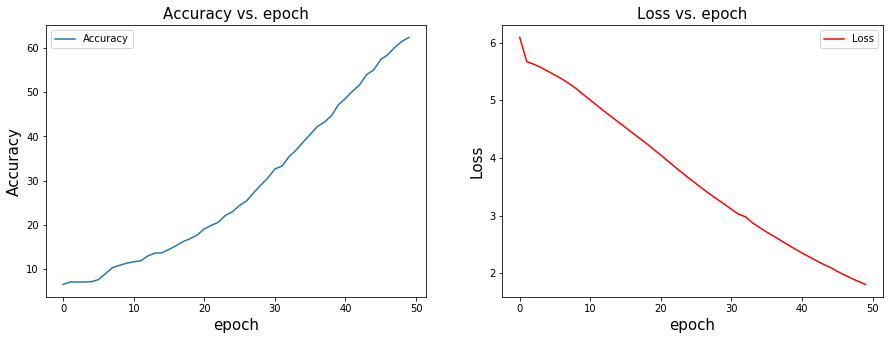

In [9]:
plot_graph(history_1l)

### Prediction

In [10]:
#predict the new words based on the input string
def prediction(model, input_string, new_wc):
    
    #loop through new requested word count
    for count in range(new_wc):

        #convert the text into sequence of mapped digits
        t2d = tokenizer.texts_to_sequences([input_string])[0]
        
        #prefix the zeros to each sequence
        t2d = pad_sequences([t2d], maxlen=max_seq-1, padding='pre')
        
        #predict the new word
        pred = model.predict_classes(t2d, verbose=0)

        #append the prediced word into the input string
        result = ""
        
        #fetch the word and the index of the predicted word
        for word, index in tokenizer.word_index.items():
            
            #check if the predicted word found and then append it
            if index == pred:
                result = word
                break           #break if the word found
                
        #append the predicted word to the input string
        input_string += " " + result
        
    #return the input + predicted string
    return input_string

# Area of Improvements

## 1) Increasing Corpus Size

In the first variation of our model we increase the size of our dataset by 100%. In the previous model we selected half of the data from the 'Silver' category of the Reuters datsaset. Our intuition behind this move is that by adding more training data the model will be able to predict future word sequences better. <br>

The number of the documents that we will working with now is 29 compared to 13 used in the previous model. The data preparation step and model architecture remains the same as the last model.

In [13]:
#read the dataset
dataset = reuters_dataset()
print('Total Documents in the dataset: ', len(dataset))

Total Documents in the dataset:  29


### Data Preparation

In [14]:
#assign digit to each number using tokenizer class
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset)

word_count = len(tokenizer.word_index) + 1
print('Total word count in the whole corpus: ', word_count)

text_to_digit = []
for element in dataset:
    t2d_element = tokenizer.texts_to_sequences([element])[0]
    for i in range(1, len(t2d_element)):
        text_to_digit.append(t2d_element[:i+1])
        
max_seq = max([len(x) for x in text_to_digit])
t2d_seq = np.array(pad_sequences(text_to_digit, 
                                 padding='pre',
                                 maxlen=max_seq))

X_train = t2d_seq[:,:-1]
print('X_train.shape: ', X_train.shape)

y_train_temp = t2d_seq[:,-1]
y_train = ku.to_categorical(y_train_temp, num_classes=word_count)
print('y_train.shape: ', y_train.shape)

Total word count in the whole corpus:  1333
X_train.shape:  (6379, 570)
y_train.shape:  (6379, 1333)


### Model

In [15]:
#initialize the network
model_ids = Sequential()

model_ids.add(Embedding(word_count, 10, input_length=max_seq-1))

#add first LSTM and Dropout regularization layer to avoid overfitting
model_ids.add(LSTM(units=100))

model_ids.add(Dense(word_count, activation='softmax'))

#compile the RNN
model_ids.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

display(Markdown('<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*  Model  Summary  \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>'))
model_ids.summary()

<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*  Model  Summary  \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 570, 10)           13330     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dense_2 (Dense)              (None, 1333)              134633    
Total params: 192,363
Trainable params: 192,363
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [16]:
history_ids = fit(model_ids, X_train, y_train, epoch=50)

<br>Training is completed! <br><br>Total training time: **8048.424 seconds** <br>Average Training time per epoch: **160.968 seconds**

C:\Users\prtk1\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### Model Training Results

<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*     Training Summary    \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>

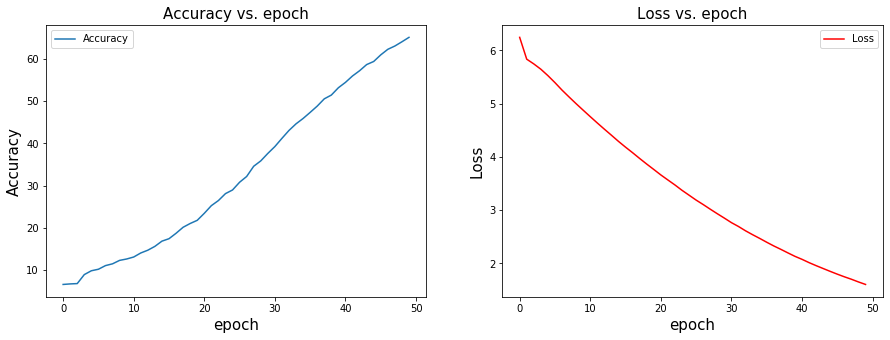

In [17]:
plot_graph(history_ids)

## 2) Stacked LSTM layers

In our second variation, we increase the depth of our model by adding two more LSTM layers.Stacked LSTMs or Deep LSTMs were introduced by Graves, et al. in their application of LSTMs to speech recognition. The intuition behind stacking LSTM layers is that we can add more levels of abstraction of input observation over time. <br>

We continue to use entire data of 'Silver' category from the Reuters dataset.

In [19]:
#initialize the network
model_ml = Sequential()

model_ml.add(Embedding(word_count, 10, input_length=max_seq-1))

#adding first LSTM layer
model_ml.add(LSTM(units=100, return_sequences=True))

#adding second LSTM layer
model_ml.add(LSTM(units=100, return_sequences=True))

#adding third LSTM layer
model_ml.add(LSTM(units=100))

model_ml.add(Dense(word_count, activation='softmax'))

#compile the RNN
model_ml.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

display(Markdown('<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*  Model  Summary  \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>'))
model_ml.summary()

<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*  Model  Summary  \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 570, 10)           13330     
_________________________________________________________________
lstm_3 (LSTM)                (None, 570, 100)          44400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 570, 100)          80400     
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1333)              134633    
Total params: 353,163
Trainable params: 353,163
Non-trainable params: 0
_________________________________________________________________


### Model Training

In [20]:
history_ml = fit(model_ml, X_train, y_train, epoch=50)    

<br>Training is completed! <br><br>Total training time: **21892.485 seconds** <br>Average Training time per epoch: **437.85 seconds**

C:\Users\prtk1\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### Model Training Results

<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*     Training Summary    \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>

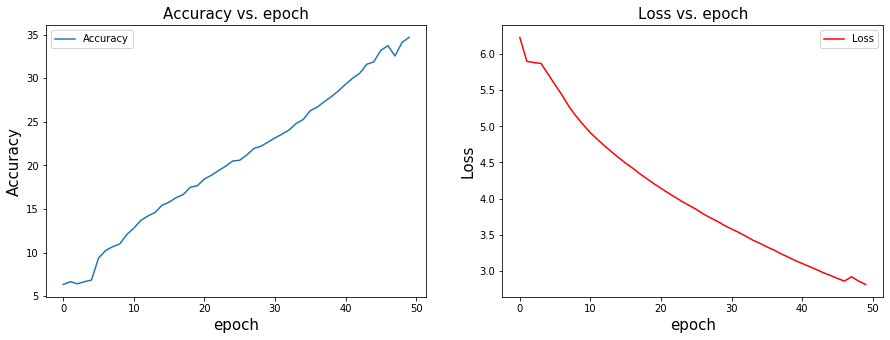

In [21]:
plot_graph(history_ml)

## 3) Adding Dropout Regularization

<b>Dropout</b> is a regularization technique for neural network models. Dropout is a technique where we randomly selected neurons are ignored during training. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.<br><br>
Below we have performed and compared the performance of the models having dropout rate 0.15.

### Model

In [25]:
#initialize the network
model_dr = Sequential()

model_dr.add(Embedding(word_count, 10, input_length=max_seq-1))

#adding first LSTM layer
model_dr.add(LSTM(units=100, return_sequences=True))
model_dr.add(Dropout(0.15))  #adding dropout layer to avoid overfitting

#adding second LSTM layer
model_dr.add(LSTM(units=100, return_sequences=True))
model_dr.add(Dropout(0.15))  #adding dropout layer to avoid overfitting

#adding third LSTM layer
model_dr.add(LSTM(units=100))
model_dr.add(Dropout(0.15))  #adding dropout layer to avoid overfitting

model_dr.add(Dense(word_count, activation='softmax'))

#compile the RNN
model_dr.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

display(Markdown('<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*  Model  Summary  \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>'))
model_dr.summary()

<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*  Model  Summary  \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 570, 10)           13330     
_________________________________________________________________
lstm_9 (LSTM)                (None, 570, 100)          44400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 570, 100)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 570, 100)          80400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 570, 100)          0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)              

### Model Training

In [26]:
history_dr = fit(model_dr, X_train, y_train, epoch=50)

<br>Training is completed! <br><br>Total training time: **11671.107 seconds** <br>Average Training time per epoch: **233.422 seconds**

C:\Users\prtk1\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### Model Training Results

<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*     Training Summary    \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>

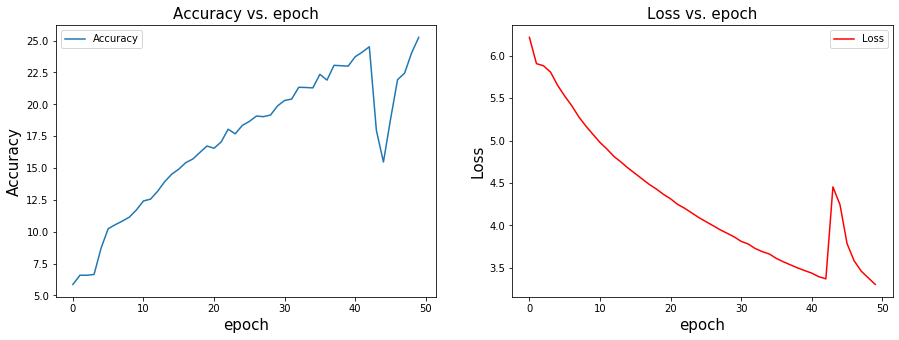

In [27]:
plot_graph(history_dr)

## 4) Increasing Number of Epochs + EarlyStopping

The final model is a culmination of all the model that we have implemented so far. In this we use the entire dataset, with 3 LSTM layers, dropout regularization, and increased number of epochs from 50 to 100 and examined the performance of the model.

### Model

In [29]:
#initialize the network
model_me = Sequential()

model_me.add(Embedding(word_count, 10, input_length=max_seq-1))

#adding first LSTM layer
model_me.add(LSTM(units=100, return_sequences=True))
model_me.add(Dropout(0.15))  #adding dropout layer to avoid overfitting

#adding second LSTM layer
model_me.add(LSTM(units=100, return_sequences=True))
model_me.add(Dropout(0.15))  #adding dropout layer to avoid overfitting

#adding third LSTM layer
model_me.add(LSTM(units=100))
model_me.add(Dropout(0.15))  #adding dropout layer to avoid overfitting

model_me.add(Dense(word_count, activation='softmax'))

#compile the RNN
model_me.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

display(Markdown('<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*  Model  Summary  \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>'))
model_me.summary()

<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*  Model  Summary  \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 570, 10)           13330     
_________________________________________________________________
lstm_12 (LSTM)               (None, 570, 100)          44400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 570, 100)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 570, 100)          80400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 570, 100)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)              

### Model Training

In [30]:
def fit_earlystop(model, X, y, epoch):
    #include timing details
    dh = display('',display_id=True)
    dh.update(md("<br>Training is in progress....."))
    t1 = time.time()

    #fitting the RNN to the training set
    es = EarlyStopping(patience=5)
    model_history = model.fit(X, y, epochs=epoch, verbose=0, callbacks=[es])

    tt = time.time()-t1
    avg_per_epoch_1l = round(tt/(model_history.epoch[-1]+1),3)
    dh.update(md("<br>Training is completed! <br><br>Total training time: **{} seconds** <br>Average Training time per epoch: **{} seconds**".format(round(tt,3), avg_per_epoch_1l)))
    
    return model_history

In [31]:
history_me = fit_earlystop(model_me, X_train, y_train, epoch=100)

<br>Training is completed! <br><br>Total training time: **20639.708 seconds** <br>Average Training time per epoch: **206.397 seconds**

C:\Users\prtk1\Anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\prtk1\Anaconda3\envs\tf-gpu\lib\site-packages\keras\callbacks\callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


### Model Training Results

<br>**\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*     Training Summary    \*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\*\***<br>

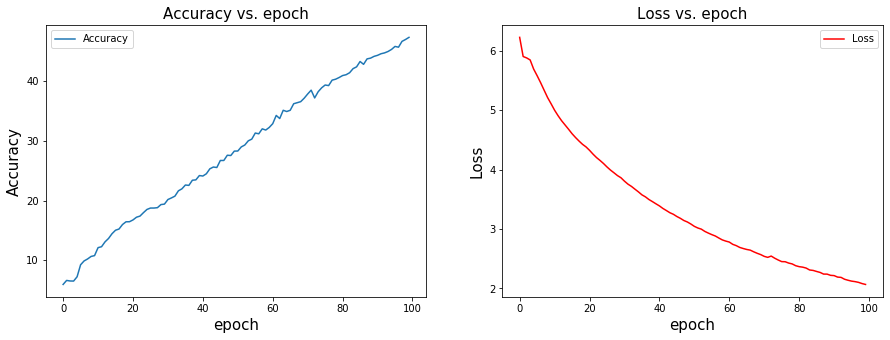

In [32]:
plot_graph(history_me)

### Experimental Results

**Index**:
* Model 1: Single Layer LSTM Model
* Model 2: Increasing Corpus Size
* Model 3: Stacked LSTM layers
* Model 4: Adding Dropout Regularization
* Model 5: Increasing Number of Epochs + EarlyStopping


In [72]:
def pred(input_string_1, new_wc_1):
    #prediction
    result_1l_1  = prediction(model_1l, input_string_1, new_wc_1)
    result_ids_1 = prediction(model_ids, input_string_1, new_wc_1)
    result_ml_1  = prediction(model_ml, input_string_1, new_wc_1)
    result_dr_1  = prediction(model_dr, input_string_1, new_wc_1)
    result_me_1  = prediction(model_me, input_string_1, new_wc_1)

    #display the results
    print('Input string:', input_string_1)
    print('Model 1: ', result_1l_1)
    print('Model 2: ', result_ids_1)
    print('Model 3: ', result_ml_1)
    print('Model 4: ', result_dr_1)
    print('Model 5: ', result_me_1)

In [94]:
#Example: 1
#take the input from the user
input_string_1 = input()   #input string
new_wc_1 = int(input())    #number of new words requested
pred(input_string_1, new_wc_1)

mercantile predicted that
10
Input string: mercantile predicted that
Model 1:  mercantile predicted that grading to figures gold finance expected the . . .
Model 2:  mercantile predicted that the only government optimism mine silver silver looks the commodity
Model 3:  mercantile predicted that the plan of 3rd the ranges > > > >
Model 4:  mercantile predicted that the mine ; ; ; ; ; ; ; ;
Model 5:  mercantile predicted that mine near helena , , , , , , ,


In [62]:
#Example: 2
#take the input from the user
input_string_1 = input()   #input string
new_wc_1 = int(input())    #number of new words requested
pred(input_string_1, new_wc_1)

silver value rose by
10
Input string:              silver value rose by
Model 1:  silver value rose by the ounces the he said 1 hecla commodity gains minted
Model 2:  silver value rose by silver & & & & & & & & &
Model 3:  silver value rose by a 2 , , , , , , , ,
Model 4:  silver value rose by the face half of the company said the thin minted
Model 5:  silver value rose by brackets , , , , , , , , ,


In [70]:
#Example: 3
#take the input from the user
input_string_1 = input()   #input string
new_wc_1 = int(input())    #number of new words requested
pred(input_string_1, new_wc_1)

expected cost
10
Input string:              expected cost
Model 1:  expected cost . . . . . . . . . .
Model 2:  expected cost hallmarked ; ; ; ; ; ; ; ; ;
Model 3:  expected cost to 698 to produce weak exchange , , , ,
Model 4:  expected cost in the end of the company said . . .
Model 5:  expected cost in the number of silver limits minging broad earnings to


In [77]:
#Example: 4
#take the input from the user
input_string_1 = input()   #input string
new_wc_1 = int(input())    #number of new words requested
pred(input_string_1, new_wc_1)

little reaction to
10
Input string: little reaction to
Model 1:  little reaction to minerals gold finance their . . . . . .
Model 2:  little reaction to removal comex the central government for two , , ,
Model 3:  little reaction to purchase the 28 of 3rd the ranges said said william
Model 4:  little reaction to be having little venture for the golden patricia property .
Model 5:  little reaction to continue , , , , , , , , ,


In [78]:
#Example: 5
#take the input from the user
input_string_1 = input()   #input string
new_wc_1 = int(input())    #number of new words requested
pred(input_string_1, new_wc_1)

Vice president
10
Input string: Vice president
Model 1:  Vice president silver per silver per let anniversary the . . .
Model 2:  Vice president to raise myra falls capacity to silver mine stake on
Model 3:  Vice president for silver futures said said it plans , , ,
Model 4:  Vice president for the mine ; ; ; ; ; ; ;
Model 5:  Vice president / / / / / / / / / /


In [79]:
#Example: 6
#take the input from the user
input_string_1 = input()   #input string
new_wc_1 = int(input())    #number of new words requested
pred(input_string_1, new_wc_1)

new york committed to
10
Input string: new york committed to
Model 1:  new york committed to despite exchange at short year 000 . . . .
Model 2:  new york committed to raise myra falls capacity to buy mine silver production on
Model 3:  new york committed to encouraging > > > > > > > > >
Model 4:  new york committed to be having little venture for the mine market . .
Model 5:  new york committed to be having 67 , , , , , , ,


In [81]:
#Example: 7
#take the input from the user
input_string_1 = input()   #input string
new_wc_1 = int(input())    #number of new words requested
pred(input_string_1, new_wc_1)

traders who are holding stocks
10
Input string: traders who are holding stocks
Model 1:  traders who are holding stocks hecla commodity gains common exchange share the gold year 000
Model 2:  traders who are holding stocks for silver yields looks the commodity exchange of the switching
Model 3:  traders who are holding stocks for the feasibility potential calls . . . . .
Model 4:  traders who are holding stocks of the golden patricia property . . . . .
Model 5:  traders who are holding stocks for silver futures inc . . . . . .


In [83]:
#Example: 8
#take the input from the user
input_string_1 = input()   #input string
new_wc_1 = int(input())    #number of new words requested
pred(input_string_1, new_wc_1)

a spokesman for the assay officers
15
Input string: a spokesman for the assay officers
Model 1:  a spokesman for the assay officers . . . . . . . . . . . . . . .
Model 2:  a spokesman for the assay officers phase to produce 6 . . . . . . . . . . .
Model 3:  a spokesman for the assay officers potential for the discovery of the south dakota has been shown by the portuguese is
Model 4:  a spokesman for the assay officers offices of the golden patricia property . . . . . . . . .
Model 5:  a spokesman for the assay officers dynamite optimism capacity processed a face value of the south dakota has owned muskeg lake


In [85]:
#Example: 9
#take the input from the user
input_string_1 = input()   #input string
new_wc_1 = int(input())    #number of new words requested
pred(input_string_1, new_wc_1)

silver futures were trading about
15
Input string: silver futures were trading about
Model 1:  silver futures were trading about . . . . . . . . . . . . . . .
Model 2:  silver futures were trading about silver & & & & & & & & & & & & & &
Model 3:  silver futures were trading about improving , , , , , , , , , , , , , ,
Model 4:  silver futures were trading about the been creek joint venture for the golden patricia property . . . . .
Model 5:  silver futures were trading about 30 soar on its rejection of 3rd silver contracts . . . . . .


In [93]:
#Example: 10
#take the input from the user
input_string_1 = input()   #input string
new_wc_1 = int(input())    #number of new words requested
pred(input_string_1, new_wc_1)

milling operations have started
10
Input string: milling operations have started
Model 1:  milling operations have started expected to commodity gains common exchange share articles gold year
Model 2:  milling operations have started to mint community guerrillas 33 . . . . .
Model 3:  milling operations have started of silver futures said said it plans , , ,
Model 4:  milling operations have started of the mine ; ; ; ; ; ; ;
Model 5:  milling operations have started for silver limits on the commodity exchange , , ,


## key Inferences

1. Based on the value of loss for the final epoch and the text generated for the 10 examples given above we can infer that model 2 and model 5 work better than the other models. <br><br>

2. The models are able to understand the relationship between the words upto a certain extent and continue adding words to an open ended sentence. <br><br>

3. In example 5, we see that the model understands the meaning of the words 'Vice President' and knows that a vice president is able to 'say' something. The prediction 'Vice President said it plans..' give us compelling evidence of the same.<br><br>

4. The models also realizes the relationship between words and numbers. In example 9, we witness model 5 predicting a number value after the input sentence 'Silver futures were trading about'. The model understoood that a number was warranted based on what it had read in the input, the model also uses the words like contracts which is a unit of futures trading.<br><br>

5. The model has certain shortcomings too. The model fails to understand how to continue a sentence given any punctuation mark. <br><br>

6. The sentences generated by the model often do make any sense which can be attributed to the lack of training data and lack of computation power to build a more complex model.<br><br>

## Future Work

1. We believe that increasing the training dataset of the model woould improve the text generation capabilities of the model multifold. <br><br>

2. Implementing pretrained word embeddings like GloVe or Word2vec would be instrumental in achieving high accuracy in text generation. <br><br>

3. Implemention techniques such as POS(Part of speech) tagging will help the model understand parts of speec and thus understand the relationship between the words better. 


## Conclusion

After having worked with image datasets for most of the projects this semester, we decided to apply ourselves and the the course material we have learned so far to tasks that all of us use use on daily basis. Lnaguage modelling tasks surround us in every aspect of our lives. We have successfully built a text generation model using an LSTM model. The models developed understand the relationship between words and sentences. We aim to understand more about text generation and other language tasks in the future. 

<h2> Acknowledgment </h2><br>
We would like to express our gratitude to Dr. Timothy Havens, who helped us along the project with his insightful notes and lectures. We would also like to thank the TAs for their guidance in moments of difficulty.

<h2>References</h2>

* Prof. Timothy Haven’s Lecture Notes.<br>
* Prof. Keith Vertanen's Speech and Language Processing notes(CS5090)<br>
* https://keras.io/preprocessing/text/<br>
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/<br>
* https://colah.github.io/posts/2014-07-NLP-RNNs-Representations/<br>